In [1]:
%matplotlib inline
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers import BertWordPieceTokenizer

# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

In [3]:
european_restaurants = pd.read_csv("data/European Restaurant Reviews.csv")

In [4]:
european_restaurants.describe()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
count,1502,1502,1502,1502,1502,1502
unique,7,7,2,1343,143,1426
top,France,The Frog at Bercy Village,Positive,Excellent,May 2014 •,I'm afraid we were very let down by this resta...
freq,512,512,1237,9,108,4


In [5]:
european_restaurants.shape

(1502, 6)

In [6]:
european_restaurants.columns = european_restaurants.columns.str.lower().str.replace(" ","_")

In [7]:
european_restaurants.country.value_counts().unique

<bound method Series.unique of country
France     512
Italy      318
Morroco    210
Cuba       146
Poland     135
Russia     100
India       81
Name: count, dtype: int64>

In [8]:
european_restaurants.review_date.min(), european_restaurants.review_date.max()

('Apr 2012 •', 'Sept 2023 •')

In [9]:
european_restaurants.dtypes

country            object
restaurant_name    object
sentiment          object
review_title       object
review_date        object
review             object
dtype: object

In [10]:
european_restaurants.drop_duplicates()

,country,restaurant_name,sentiment,review_title,review_date,review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...
...,...,...,...,...,...,...
1492,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...
1493,Cuba,Old Square (Plaza Vieja),Negative,Tourist Trap,Oct 2016 •,Food and service was awful. Very pretty stop. ...
1494,Cuba,Old Square (Plaza Vieja),Negative,"Over-renovated, or in a state of transition?",Oct 2016 •,"I was disappointed with the Plaza Vieja, to wh..."
1495,Cuba,Old Square (Plaza Vieja),Negative,"The square is beautiful, but that's it.",Oct 2016 •,Beautiful in the square and up to two blocks o...


In [11]:
european_restaurants.review_date = european_restaurants.review_date.str[:-1]

#### Observations were 1502 and after drop duplicates they becaome 1453. Most represented country is France. Time range is form April 2012 till September 2023

### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

In [12]:
european_restaurants.sentiment.value_counts().unique

<bound method Series.unique of sentiment
Positive    1237
Negative     265
Name: count, dtype: int64>

In [13]:
for sentiment, group_data in european_restaurants.groupby("sentiment"):
    print(sentiment, group_data.review.str.len().mean())

Negative 761.0075471698113
Positive 281.9102667744543


#### By finding and compare the mean value we can see that positive comments are shorter. 

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

#### First, i will check for NA reviews and will drop them

In [14]:
european_restaurants[european_restaurants.review.isna()]

,country,restaurant_name,sentiment,review_title,review_date,review


In [15]:
for count_review, data_group in european_restaurants.groupby("review"):
    if len(data_group) > 1:
        print(data_group)

    country                        restaurant_name sentiment  \
107  France              The Frog at Bercy Village  Negative   
132  France              The Frog at Bercy Village  Negative   
524   Italy  Ad Hoc Ristorante (Piazza del Popolo)  Negative   
547   Italy  Ad Hoc Ristorante (Piazza del Popolo)  Negative   

                                          review_title review_date  \
107  rotten starter - no apology. otherwise ok albe...   Dec 2011    
132  rotten starter - no apology. otherwise ok albe...   Dec 2011    
524  rotten starter - no apology. otherwise ok albe...   Dec 2011    
547  rotten starter - no apology. otherwise ok albe...   Dec 2011    

                                                review  
107  10 of us ate on christmas day at Ad Hoc - we w...  
132  10 of us ate on christmas day at Ad Hoc - we w...  
524  10 of us ate on christmas day at Ad Hoc - we w...  
547  10 of us ate on christmas day at Ad Hoc - we w...  
    country                        restaura

#### There are duplicates, which have to be droped

In [16]:
european_restaurants = european_restaurants.drop_duplicates()

In [17]:
european_restaurants.review.str.len().sort_values(ascending  = False)

102     3679
27      3555
66      3516
98      3106
101     3087
        ... 
1493      76
536       71
559       71
119       71
183       10
Name: review, Length: 1453, dtype: int64

In [18]:
all_reviews = "".join(european_restaurants.review.ravel()).lower()

In [19]:
Counter(all_reviews)

Counter({' ': 90872,
         'e': 53939,
         't': 35644,
         'a': 35397,
         'o': 28707,
         'i': 27455,
         'n': 25711,
         'r': 25399,
         's': 24543,
         'h': 18296,
         'd': 17517,
         'l': 17296,
         'u': 11730,
         'c': 11457,
         'w': 11073,
         'f': 10187,
         'm': 9007,
         'y': 8330,
         'g': 7869,
         'p': 7195,
         '.': 6454,
         'b': 6173,
         'v': 5991,
         ',': 3194,
         'k': 3045,
         '\n': 1416,
         '!': 1208,
         'x': 1051,
         "'": 628,
         'j': 571,
         'z': 567,
         'q': 485,
         '-': 430,
         ')': 366,
         '0': 360,
         '(': 315,
         '1': 267,
         '2': 206,
         '’': 183,
         '5': 173,
         '"': 163,
         '3': 143,
         ':': 128,
         '?': 92,
         '&': 89,
         '4': 85,
         '/': 80,
         ';': 62,
         '8': 61,
         'é': 61,
         '*'

In [20]:
"" in "".join(european_restaurants.review.ravel()).split(" ")

True

In [21]:
european_restaurants.review = european_restaurants.review.apply(lambda x: " ".join(x.split())) 

#### I remove the empty spaces in each review

#### Problem 4. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

In [22]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nushi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop_words = stopwords.words("english")

In [24]:
most_common_words = []
for sentiment, group_data in european_restaurants.groupby("sentiment"):
    all_words = "".join(group_data.review.str.lower().ravel()).split(" ")
    words_review = np.array([word for word in all_words if word not in stop_words])
    most_common_words.append(words_review)
    print(sentiment, Counter(words_review).most_common(30))

Negative [('food', 162), ('restaurant', 115), ('wine', 108), ('us', 108), ('would', 95), ('service', 93), ('good', 93), ('one', 92), ('table', 85), ('like', 67), ('could', 66), ('menu', 64), ('-', 63), ('asked', 62), ('really', 61), ('tasting', 60), ('ad', 58), ('place', 58), ('waitress', 58), ('even', 57), ('time', 56), ('meal', 53), ('many', 52), ('minutes', 52), ('truffle', 51), ('nice', 50), ('main', 50), ('took', 46), ('hoc', 46), ('go', 46)]
Positive [('food', 532), ('great', 439), ('good', 389), ('service', 356), ('place', 274), ('restaurant', 261), ('nice', 244), ('really', 207), ('staff', 200), ('us', 188), ('wine', 184), ('friendly', 177), ('would', 173), ('menu', 163), ('-', 159), ('recommend', 153), ('best', 145), ('lovely', 142), ('also', 141), ('one', 131), ('back', 129), ('delicious', 124), ('time', 123), ('excellent', 121), ('well', 116), ('definitely', 114), ('highly', 112), ('visit', 108), ('beer', 106), ('ad', 105)]


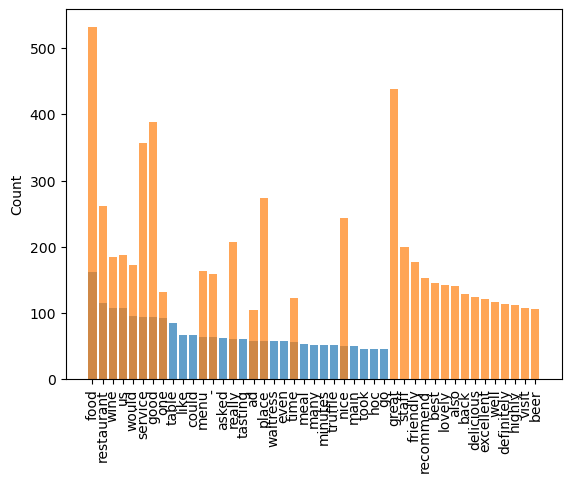

In [26]:
sentiment_negative = Counter(most_common_words[0]).most_common(30)
sentiment_positive = Counter(most_common_words[1]).most_common(30)

plt.bar([word for word, frequency in sentiment_negative],[frequency for word, frequency in sentiment_negative],alpha = 0.7)
plt.bar([word for word, frequency in sentiment_positive],[frequency for word, frequency in sentiment_positive], alpha = 0.7)

plt.ylabel("Count")
plt.xticks(rotation=90)

plt.show()

#### Problem 5. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

### Problem 6. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

### Problem 7. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

### Problem 8. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

### \* Problem 9. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.